In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import ee, eemont
import geemap
import geemap.colormaps as geecm

import matplotlib.pyplot as plt
import cmocean

# 1. Initialization GEE

In [2]:
ee.Authenticate()
ee.Initialize()

# 2. Load GEE datasets + parameters

In [3]:
dem_glo30 = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [4]:
scale = 30
projection = "EPSG:4326" 

In [113]:
EU_lia = ee.FeatureCollection('') # Add EU
fc_lia = ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/glaciers_1850_final_mars_2025')
geom_lia = ee.Geometry.convexHull(fc_lia.geometry())
alpes_FR = ee.FeatureCollection('users/aguerou/ice_and_life/erable_2025/data_ancillary/alpes_francaises')

# Europe RGI Boundaries
geom_RGI_2000=ee.FeatureCollection('projects/sat-io/open-datasets/RGI/RGI_VECTOR_MERGED_V7')
geom_RGI_2015=ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/c3s_gi_rgi11_s2_2015_v2')

In [71]:
# RGI in the FR alps only
alpes_geom = geom_alpes_FR.geometry()

RGI_2000_FR = ee.FeatureCollection('projects/ee-roniritzganem/assets/EU_GL/RGI_FR/RGI_2000_FR')
RGI_2015_FR = ee.FeatureCollection('projects/ee-roniritzganem/assets/EU_GL/RGI_FR/RGI_2015_FR')

In [72]:
years = range(1985, 2025)

## Pre-processing data (before gap filling and smoothing)

In [73]:

# Créer une liste d'images en important les fichiers du répertoire
Landsat_annualCollection_index= ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/landsat_annual_median_index/Landsat_{year}")
    for year in years
])

## Post-processing data (after gap filling and smoothing)

In [74]:
#Importing TS IC

gbr_ts_filled_smooth=ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/Time_series_GBR_NDWI_TIR/GBR/GBR_TS_filled_smooth_{year}")
    for year in years
])

Seuils de référence

In [75]:
SlopeThresh = 30
AltitudeThresh = 1000

#Cloud correction
cloudThresh = 0.4
cloudBuff = 1000
cloudCover = 50

In [76]:
#Seuils Test
# 1,8 https://doi.org/10.1016/j.rse.2021.112862
GlacierThreshold_1 = 2
GlacierThreshold_2 = 3
GlacierThreshold_3 = 4
GlacierThreshold_4 = 6


In [77]:
palette_diff = geecm.get_palette('RdBu', n_class=7)
palette_ndwi = geecm.get_palette('viridis', n_class=7)
palette_gbr = cmocean.cm.ice
palette_dem = cmocean.cm.solar
palette_slope = cmocean.cm.matter
visParams_diff = {'min': -2, 'max': 2, 'palette': palette_diff}
visParams_ndwi = {'min': 0.0, 'max': 0.5, 'palette': palette_ndwi}
visParams_gbr = {'min': 0, 'max': 10, 'palette': palette_gbr}
visParams_dem = {'min': 1000, 'max': 4000, 'palette': palette_dem}
visParams_slope = {'min': 20, 'max': 60, 'palette': palette_slope}

vis_params_landsat = {
    'bands': ['RED', 'GREEN', 'BLUE'],  # RGB
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.3
}

# 3 palettes glacier avec nuances différentes (au choix ici pour exemple)
visGLACIER_1 = {"min": 0, "max": 1, "palette": ["#808080", "#228B22"]}   # Vert forêt
visGLACIER_2 = {"min": 0, "max": 1, "palette": ["#808080", "#FF00FF"]}   # Magenta
visGLACIER_3 = {"min": 0, "max": 1, "palette": ["#808080", "#00FFFF"]}   # Cyan
visGLACIER_4 = {"min": 0, "max": 1, "palette": ["#808080", "#FF0000"]}   # Rouge vif
visWATER = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}  # Cyan → Bleu → Bleu foncé
# visWATER_2 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}
# visWATER_3 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}

visVEGET = {"min": 0, "max": 1, "palette": ["#808080", "#33a02c"]}

# 3. FUNCTIONS

In [78]:
def classifyGlacier(image, seuil):
    temp = image.select('GBR').gt(seuil)
    mask = temp.where(temp.gte(1), 1)
    return image.addBands(mask.rename('GLACIER').toInt())

In [79]:
def get_slope(image):
    return ee.Terrain.slope(image)

In [80]:
def removeValley(image):
    return image.updateMask(valley_mask)

In [81]:
def mask_clip_lia(image): 
    return image.updateMask(image.neq(0))


In [82]:
def clip_to_geometry(image,geom):
    return image.clip(geom)

generating map for diff tresh

In [83]:
def generate_seuil_for_years_preprocess(year_selected, Threshold):
    # Select the annual image corresponding to the chosen year
    image_annee = (Landsat_annualCollection_index
                   .filter(ee.Filter.eq('year', year_selected))
                   .first())
    
    # Convert the selected image into an ImageCollection
    image_finale = ee.ImageCollection(image_annee)
    
    # Process the image using the given threshold:
    # 1. Apply glacier classification using the threshold
    # 2. Apply selfMask to keep only classified (non-zero) pixels
    Seuil = image_finale.map(lambda image: classifyGlacier(image, Threshold))\
                         .map(lambda img: img.selfMask())
    
    # Select only the 'GLACIER' band from the classified images
    Seuil_selected = Seuil.select(['GLACIER'])

    # Merge all images into a single mosaic image
    aire_threshold = Seuil_selected.mosaic()
    
    return aire_threshold

In [84]:
def generate_seuil_for_years_postprocess(year_selected, Threshold):
    # Select the annual image corresponding to the chosen year
    image_annee = (gbr_ts_filled_smooth
                   .filter(ee.Filter.eq('year', year_selected))
                   .first())
    
    # Convert the selected image into an ImageCollection
    image_finale = ee.ImageCollection(image_annee)
    
    # Process the image using the given threshold:
    # 1. Apply glacier classification using the threshold
    # 2. Apply selfMask to keep only classified (non-zero) pixels
    Seuil = image_finale.map(lambda image: classifyGlacier(image, Threshold))\
                         .map(lambda img: img.selfMask())
    
    # Select only the 'GLACIER' band from the classified images
    Seuil_selected = Seuil.select(['GLACIER'])

    # Merge all images into a single mosaic image
    aire_threshold = Seuil_selected.mosaic()
    
    return aire_threshold

Comparing with RGI 2000 and 2015

In [110]:
def glacier_accuracy(rgi_geom, aire_threshold):
    # Compute the area (in km²) for each feature in the RGI geometry
    rgi_with_area = rgi_geom.map(
        lambda feature: feature.set(
            {'areakm²': feature.geometry().area().divide(1e6)}))  # Convert m² to km²

    # Calculate the total area of all RGI polygons
    surface_totale_rgi = rgi_with_area.aggregate_sum('areakm²')

    # ---- Glacier area inside RGI ----
    # Clip the threshold image to the RGI geometry
    # Multiply by pixel area 
    # Use reduceRegion to sum the glacier-covered area within RGI
    glacier_in_rgi = aire_threshold.clip(rgi_geom).select('GLACIER') \
        .multiply(ee.Image.pixelArea()) \
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geom_lia,   # Study area geometry
            scale=30,
            crs=projection,
            maxPixels=1e9
        ).getNumber('GLACIER').divide(1e6)  # Convert m² to km²

    # ---- Total glacier area in the entire study area ----
    glacier_total = aire_threshold.select('GLACIER') \
        .multiply(ee.Image.pixelArea()) \
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geom_lia,
            scale=30,
            crs=projection,
            maxPixels=1e9
        ).getNumber('GLACIER').divide(1e6)

    # ---- Commission Error ----
    # Measures over-detection (glacier area outside RGI)
    commission_error = (1 - (glacier_in_rgi.divide(glacier_total))) * 100

    # ---- Completeness ----
    # Measures how much of the RGI area is covered by detected glacier
    completude = glacier_in_rgi.divide(surface_totale_rgi).multiply(100)

    # Return both metrics as outputs
    return commission_error, completude

Visualisation if necessary

In [86]:
def afficher_carte_seuils(year_selected):

    Map = geemap.Map(center=[45.9, 6.8], zoom=7)
    Map.setCenter(6.5, 45.5, 8)

    Map.addLayer(fc_lia, {}, 'LIA')
    Map.add_basemap('SATELLITE')
    Map.layers[-1].opacity = 0.5

    #Map.addLayer(Landsat_processed_2000, vis_params_landsat, f'Landsat {year_selected} - Moyenne août {year_selected}')

    Map.addLayer(geom_RGI_2000.style(color='blue', width=1), {}, 'RGI 2000 ')
    Map.addLayer(geom_RGI_2015.style(color='white', width=1),{}, 'RGI 2015 ')


    
    for i in range(1, 5):
        threshold_value = globals()[f"GlacierThreshold_{i}"]  
        seuil_image = generate_seuil_for_years(year_selected, threshold_value)
        vis = globals()[f"visGLACIER_{i}"]
    
        vector = seuil_image.select('GLACIER').reduceToVectors(
            geometryType='polygon',
            reducer=ee.Reducer.countEvery(),
            scale=30,
            geometry=geom_lia,
            labelProperty='zone',
            maxPixels=1e13
            ).style(**{
            'color': vis['palette'][1],
            'fillColor': '00000000',
            'width': 1
             })

        #Map.addLayer(vector, {}, f'Glacier_Seuil_{i} - Contours')
        Map.addLayer(seuil_image.select('GLACIER'), vis, f'Glacier_Seuil{i}')

    Map.addLayer(geom_RGI_FR_2000.style(color='blue', width=1), {}, 'RGI 2000 FR_bis')
    Map.addLayer(geom_RGI_FR_2015.style(color='white', width=1),{}, 'RGI 2015 FR_bis')
    
    return Map

# II. Terrain data / Timeseries Landsat

Terrain

In [87]:
dem = ee.ImageCollection(dem_glo30).filterBounds(fc_lia).select("DEM")
dem_mosaic = dem.mosaic().clip(fc_lia)
slope = dem.map(get_slope).mosaic().clip(fc_lia) \
#need to map on single image for slope function to work fine

slope_mask = slope.lt(SlopeThresh)
valley_mask = dem_mosaic.gt(AltitudeThresh)

# 4. Tresh calculation

preprocessing

In [114]:
Seuil1_2000_preprocess=generate_seuil_for_years_preprocess(2000,GlacierThreshold_1)
Seuil2_2000_preprocess=generate_seuil_for_years_preprocess(2000,GlacierThreshold_2)
Seuil3_2000_preprocess=generate_seuil_for_years_preprocess(2000,GlacierThreshold_3)
Seuil4_2000_preprocess=generate_seuil_for_years_preprocess(2000,GlacierThreshold_4)


In [115]:
Seuil1_2015_preprocess=generate_seuil_for_years_preprocess(2015,GlacierThreshold_1)
Seuil2_2015_preprocess=generate_seuil_for_years_preprocess(2015,GlacierThreshold_2)
Seuil3_2015_preprocess=generate_seuil_for_years_preprocess(2015,GlacierThreshold_3)
Seuil4_2015_preprocess=generate_seuil_for_years_preprocess(2015,GlacierThreshold_4)

postprocessing

In [116]:
Seuil1_2000_postprocess=generate_seuil_for_years_postprocess(2000,GlacierThreshold_1)
Seuil2_2000_postprocess=generate_seuil_for_years_postprocess(2000,GlacierThreshold_2)
Seuil3_2000_postprocess=generate_seuil_for_years_postprocess(2000,GlacierThreshold_3)
Seuil4_2000_postprocess=generate_seuil_for_years_postprocess(2000,GlacierThreshold_4)


In [117]:
Seuil1_2015_postprocess=generate_seuil_for_years_postprocess(2015,GlacierThreshold_1)
Seuil2_2015_postprocess=generate_seuil_for_years_postprocess(2015,GlacierThreshold_2)
Seuil3_2015_postprocess=generate_seuil_for_years_postprocess(2015,GlacierThreshold_3)
Seuil4_2015_postprocess=generate_seuil_for_years_postprocess(2015,GlacierThreshold_4)

# Threshold Evaluation

In [122]:
# List of studied years
years_studied = [2000, 2015]

# ---- Threshold sets for preprocessing ----
seuils_preprocess_2000 = [
    (GlacierThreshold_1, Seuil1_2000_preprocess),
    (GlacierThreshold_2, Seuil2_2000_preprocess),
    (GlacierThreshold_3, Seuil3_2000_preprocess),
    (GlacierThreshold_4, Seuil4_2000_preprocess)
]

seuils_preprocess_2015 = [
    (GlacierThreshold_1, Seuil1_2015_preprocess),
    (GlacierThreshold_2, Seuil2_2015_preprocess),
    (GlacierThreshold_3, Seuil3_2015_preprocess),
    (GlacierThreshold_4, Seuil4_2015_preprocess)
]

# ---- Threshold sets for postprocessing ----
seuils_postprocess_2000 = [
    (GlacierThreshold_1, Seuil1_2000_postprocess),
    (GlacierThreshold_2, Seuil2_2000_postprocess),
    (GlacierThreshold_3, Seuil3_2000_postprocess),
    (GlacierThreshold_4, Seuil4_2000_postprocess)
]

seuils_postprocess_2015 = [
    (GlacierThreshold_1, Seuil1_2015_postprocess),
    (GlacierThreshold_2, Seuil2_2015_postprocess),
    (GlacierThreshold_3, Seuil3_2015_postprocess),
    (GlacierThreshold_4, Seuil4_2015_postprocess)
]

# Initialize list to store results
results = []

# --- Function to evaluate and collect accuracy metrics for each threshold ---
def evaluation(year, seuils, rgi_geom, label_type):
    for threshold_value, threshold_image in seuils:
        commission_error, completude = glacier_accuracy( rgi_geom, threshold_image)
        results.append({
            "year": year,
            "Type": label_type,
            "Thresh value": threshold_value,
            "Commission (%)": commission_error.getInfo(),
            "Completness (%)": completude.getInfo()
        })

# Evaluate thresholds for each case
evaluation(2000, seuils_preprocess_2000, RGI_2000_FR, "Preprocessing")
evaluation(2000, seuils_postprocess_2000, RGI_2000_FR, "Postprocessing")
evaluation(2015, seuils_preprocess_2015, RGI_2015_FR, "Preprocessing")
evaluation(2015, seuils_postprocess_2015, RGI_2015_FR, "Postprocessing")

# Create a flat DataFrame from the collected results
df_flat = pd.DataFrame(results)

# Pivot the DataFrame: index = (Type, Threshold), columns = Year
df_pivot = df_flat.pivot(index=["Type", "Thresh value"], columns="year", values=["Commission (%)", "Completness (%)"])

# Reorganize columns to make the year the top-level index
df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1, level=0)

# Compute average Commission and Completeness across years for each threshold
df_moyennes = df_pivot.groupby(level=1, axis=1).mean()

# Add 'Mean' columns to the DataFrame
df_pivot[("Mean", "Commission (%)")] = df_moyennes["Commission (%)"]
df_pivot[("Mean", "Completness (%)")] = df_moyennes["Completness (%)"]

# Sort columns to place 'Mean' at the end
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Final display
print("\nEvaluation of thresholds for years 2000 and 2015 (Preprocessing and Postprocessing)")
print(df_pivot)


Evaluation of thresholds for years 2000 and 2015 (Preprocessing and Postprocessing)
year                                  2000                           2015  \
                            Commission (%) Completness (%) Commission (%)   
Type           Thresh value                                                 
Postprocessing 2                 31.826812       90.939819      39.685916   
               3                 23.888594       87.974806      29.290709   
               4                 18.895259       85.285866      22.937536   
               6                 12.528180       80.454114      15.171473   
Preprocessing  2                 21.817657       87.366301      12.480947   
               3                 15.148200       83.379353       7.754557   
               4                 11.634671       80.334356       5.646330   
               6                  7.692562       75.302553       3.463613   

year                                                  Mean         


---------------------------------------------

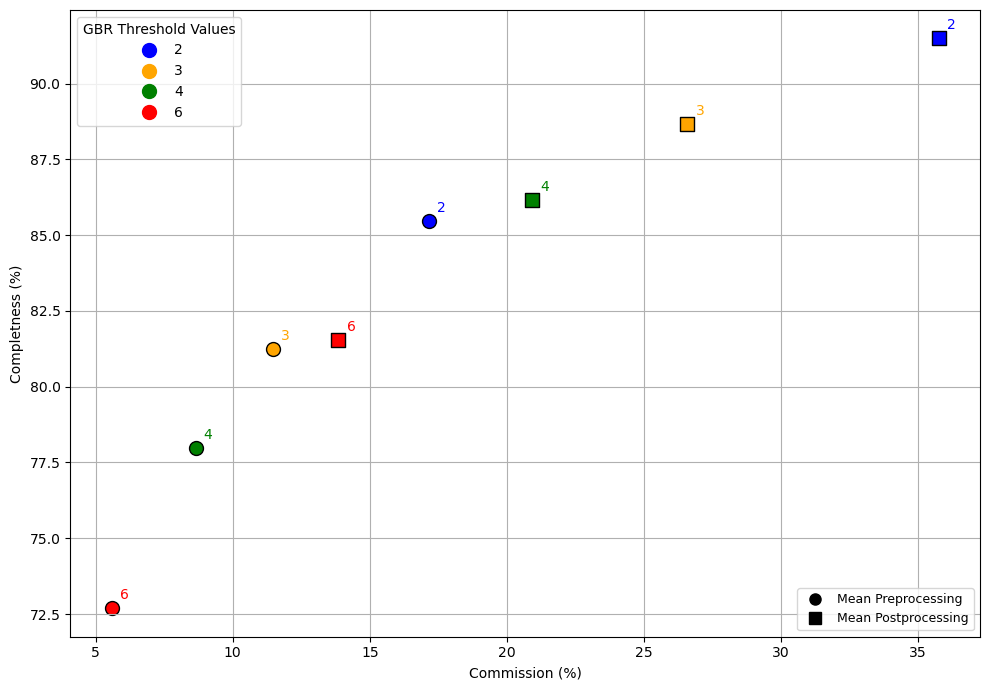

In [124]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

threshold_colors = {
    GlacierThreshold_1: 'blue',
    GlacierThreshold_2: 'orange',
    GlacierThreshold_3: 'green',
    GlacierThreshold_4: 'red',
}

df_preprocess = df_pivot.loc['Preprocessing', ('Mean',)]
df_postprocess = df_pivot.loc['Postprocessing', ('Mean',)]

fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot Postprocessing
for threshold in df_postprocess.index:
    x = df_postprocess.loc[threshold, 'Commission (%)']
    y = df_postprocess.loc[threshold, 'Completness (%)']
    color = threshold_colors.get(threshold, 'black')
    ax.scatter(x, y, color=color, marker='s', s=100, edgecolors='black')
    ax.annotate(f"{threshold}", (x + 0.3, y + 0.3), fontsize=10, color=color)

# Scatter plot Preprocessing
for threshold in df_preprocess.index:
    x = df_preprocess.loc[threshold, 'Commission (%)']
    y = df_preprocess.loc[threshold, 'Completness (%)']
    color = threshold_colors.get(threshold, 'black')
    ax.scatter(x, y, color=color, marker='o', s=100, edgecolors='black')
    ax.annotate(f"{threshold}", (x + 0.3, y + 0.3), fontsize=10, color=color)

# Axes and grid
ax.set_xlabel("Commission (%)")
ax.set_ylabel("Completness (%)")
ax.grid(True)

# Legends
mean_legend = [
    Line2D([0], [0], marker='o', color='black', label='Mean Preprocessing', linestyle='None', markersize=8),
    Line2D([0], [0], marker='s', color='black', label='Mean Postprocessing', linestyle='None', markersize=8),
]

threshold_legend = [
    Line2D([0], [0], marker='o', color=color, linestyle='None', markersize=10, label=str(threshold))
    for threshold, color in threshold_colors.items()
]

legend1 = ax.legend(handles=threshold_legend, loc='upper left', title="GBR Threshold Values", frameon=True)
ax.add_artist(legend1)
ax.legend(handles=mean_legend, loc='lower right', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

Post Process only

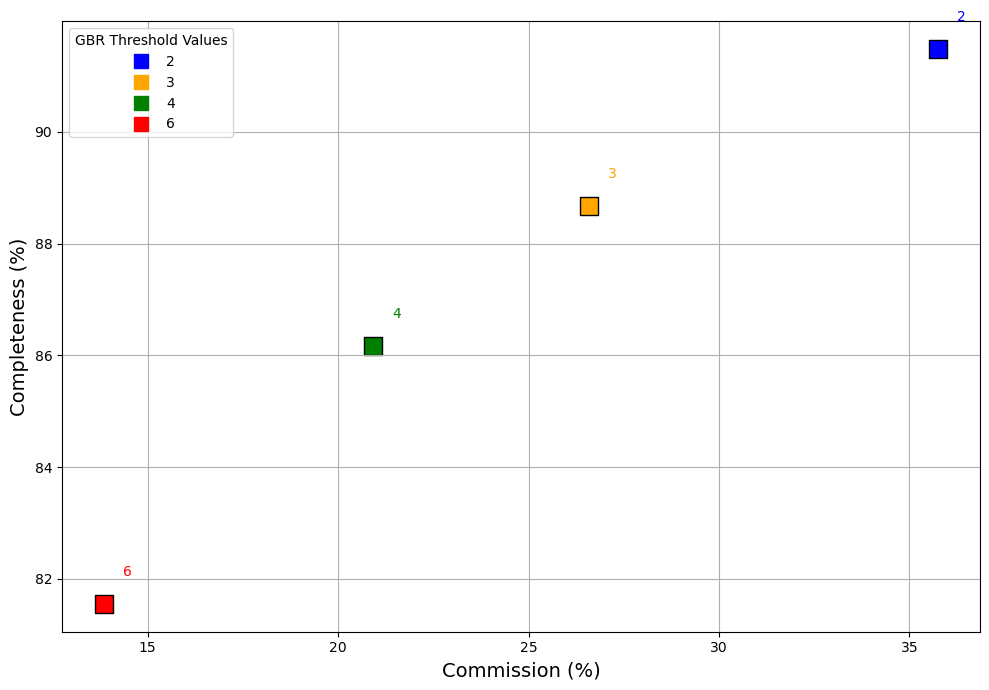

In [127]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Color mapping for thresholds
threshold_colors = {
    GlacierThreshold_1: 'blue',
    GlacierThreshold_2: 'orange',
    GlacierThreshold_3: 'green',
    GlacierThreshold_4: 'red',
}

# Extract mean postprocessing data
df_postprocess = df_pivot.loc['Postprocessing', ('Mean',)]

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))

# Plot postprocessing points only
for threshold in df_postprocess.index:
    x = df_postprocess.loc[threshold, 'Commission (%)']
    y = df_postprocess.loc[threshold, 'Completness (%)']
    color = threshold_colors.get(threshold, 'black')
    ax.scatter(x, y, color=color, marker='s', s=150, edgecolors='black')
    ax.annotate(f"{threshold}", (x + 0.5, y + 0.5), fontsize=10, color=color)

# Axes formatting
ax.set_xlabel("Commission (%)", fontsize=14)
ax.set_ylabel("Completeness (%)", fontsize=14)
ax.grid(True)

# Legend for thresholds
threshold_legend = [
    Line2D([0], [0], marker='s', color=color, linestyle='None', markersize=10, label=str(threshold))
    for threshold, color in threshold_colors.items()
]

ax.legend(handles=threshold_legend, loc='upper left', title="GBR Threshold Values", frameon=True, fontsize=10)

plt.tight_layout()
plt.show()